In [71]:
import os, io
import glob
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import pywt
from scipy.interpolate import interp1d

In [21]:
for x, y in enumerate(composites):
    print(x, y)

0 ../results/Composites\SS316A356_001\SS316A356_001_secondary_data.csv
1 ../results/Composites\SS316A356_002\SS316A356_002_secondary_data.csv
2 ../results/Composites\SS316A356_003\SS316A356_003_secondary_data.csv
3 ../results/Composites\SS316A356_004\SS316A356_004_secondary_data.csv
4 ../results/Composites\SS316A356_005\SS316A356_005_secondary_data.csv
5 ../results/Composites\SS316A356_006\SS316A356_006_secondary_data.csv
6 ../results/Composites\SS316A356_007\SS316A356_007_secondary_data.csv
7 ../results/Composites\SS316A356_008\SS316A356_008_secondary_data.csv
8 ../results/Composites\SS316A356_009\SS316A356_009_secondary_data.csv
9 ../results/Composites\SS316A356_010\SS316A356_010_secondary_data.csv
10 ../results/Composites\SS316A356_011\SS316A356_011_secondary_data.csv
11 ../results/Composites\SS316A356_012\SS316A356_012_secondary_data.csv
12 ../results/Composites\SS316A356_013\SS316A356_013_secondary_data.csv
13 ../results/Composites\SS316A356_014\SS316A356_014_secondary_data.csv
14

In [57]:
ss316_paths = glob.glob("../results/SS316_3D/**/*secondary_data.csv", recursive = True)
SS316_12in = [ss316_paths[x] for x in [-2,-1]]
SS316_18in = [ss316_paths[x] for x in [15, 16, 17, 18]]

A356_paths = glob.glob("../results/A356/**/*secondary_data.csv", recursive = True)
A356_12in = [A356_paths[x] for x in [4,5,6,7,8]]
A356_18in = [A356_paths[x] for x in [0,1,10,11,12,13,14]]

composites = glob.glob("../results/Composites/**/*secondary_data.csv", recursive = True)
SC13_12in = [composites[x] for x in [7,12,13,14,15]]
SC13_18in = [composites[x] for x in [24,32,33,34]]
SC23_12in = [composites[x] for x in [8,11,19,20]]
SC23_18in = [composites[x] for x in [26,39,40,41,42]]
GD13_12in = [composites[x] for x in [9,16,17,18]]
GD13_18in = [composites[x] for x in [25,28,29,30,31]]
GD23_12in = [composites[x] for x in [10, 21, 22,23]]
GD23_18in = [composites[x] for x in [6,27,35,36,37,38]]

file_lists = [SS316_12in, A356_12in, SC13_12in, SC23_12in, GD13_12in, GD23_12in]
#file_lists = [SS316_18in, A356_18in, SC13_18in, SC23_18in, GD13_18in, GD23_18in]

legend_idx = [0,1,2,3,4,5]
legends = ["SS316", "A356", "SS316-A356 SC 0.33", "SS316-A356 SC 0.66", "SS316-A356 GD 0.33", "SS316-A356 GD 0.66"]
line_mode = ["solid", "solid", "solid", "solid", "solid", "solid"]
color = ["blue", "red", "orange", "cornflowerblue", "coral", "green"]


fig_path = "../results/CompositeFigures_V1_12in" # Change this!
os.makedirs(fig_path, exist_ok=True)

In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

def det_average_curve(files, x , y, x_coeff, y_coeff): 
    
    all_curves = []  # List to store interpolated stress curves
    
    # First pass to find the common strain range
    x_min = 0
    x_max = np.inf
    
    for file in files:
        data = pd.read_csv(file)
    
        x_vals = data[x].values * x_coeff
        y_vals = data[y].values * y_coeff 
    
        x_abs = np.abs(x_vals)  # Work with positive values
        y_abs = np.abs(y_vals)  # Work with positive values too
    
        # Update common maximum x_val
        x_max = min(x_max, x_abs.max())
    
    # Define a common fine strain grid
    xs = np.arange(0, x_max, 1e-5) # 20K points approx
    print(f"Lenght of fitted spline {xs.shape[0]}")
    
    # Second pass to interpolate
    for file in files:
        data = pd.read_csv(file)
    
        x_vals = data[x].values * x_coeff
        y_vals = data[y].values * y_coeff 
    
        x_abs = np.abs(x_vals)  # Work with positive values
        y_abs = np.abs(y_vals)  # Work with positive values too
    
        # --- Fix: sort and remove duplicates ---
        #plt.plot(x_vals, y_vals, label=os.path.basename(file))
        sort_idx = np.argsort(x_abs)
        x_abs = x_abs[sort_idx]
        y_abs = y_abs[sort_idx]
    
        unique_x, unique_indices = np.unique(x_abs, return_index=True)
        unique_y = y_abs[unique_indices]
    
        # Safe interpolation
        cs = CubicSpline(unique_x, unique_y)
        interpolated_y = cs(xs)
        all_curves.append(interpolated_y)
    
        #Plot each curve
        
        #plt.plot(unique_x, unique_y, label=os.path.basename(file), linestyle="--")
    
    
    # Compute the average curve
    all_curves = np.array(all_curves)
    average_y = np.mean(all_curves, axis=0)
    
    # Plot average
    #plt.plot(xs, average_y, color='black', linewidth=3, label="Average Curve")
    
    #plt.xlabel("Engineering Strain")
    #plt.ylabel("Engineering Stress (MPa)")
    #plt.legend()
    #plt.grid(True)
    plt.show()
    return xs, average_y



Lenght of fitted spline 25589
Lenght of fitted spline 23240
Lenght of fitted spline 25589
Lenght of fitted spline 23240


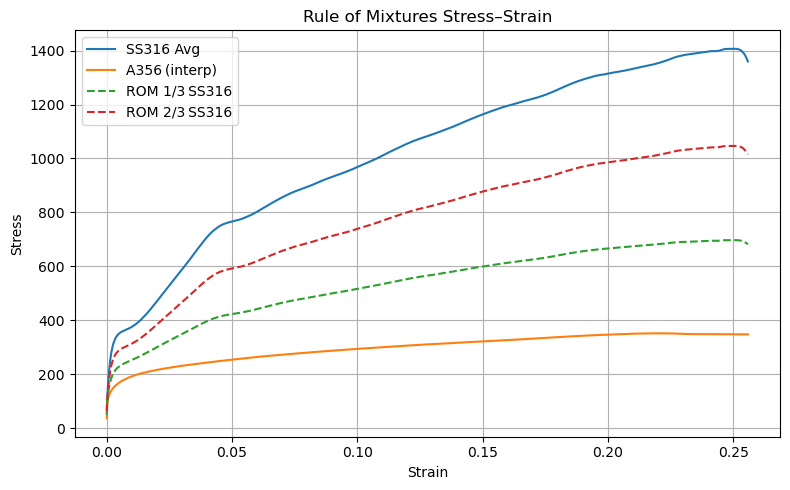

In [84]:
import numpy as np
from scipy.interpolate import interp1d

def rule_of_mixtures(SS316, A356, xcolumn, ycolumn, vf_SS=0.33, scale_x=1, scale_y=-1000):
    """
    Compute averaged stress–strain curves and two rule‐of‐mixtures blends
    between SS316 and A356.

    Parameters
    ----------
    SS316 : path or DataFrame
        Input data for SS316 (passed to det_average_curve).
    A356 : path or DataFrame
        Input data for A356 (passed to det_average_curve).
    xcolumn : str
        Name of the strain column.
    ycolumn : str
        Name of the stress column.
    vf_SS : float, optional
        Volume fraction of SS316 (defaults to 0.33).
    scale_x : float, optional
        Factor to multiply raw strain by in det_average_curve (e.g. 1).
    scale_y : float, optional
        Factor to multiply raw stress by in det_average_curve (e.g. -1000).

    Returns
    -------
    strain_common : ndarray
        The averaged strain array (from SS316).
    stress_SS316 : ndarray
        The averaged SS316 stress array.
    stress_A356_interp : ndarray
        A356 stress, interpolated onto the SS316 strain grid.
    stress_th_13 : ndarray
        Rule‐of‐mixtures stress with 1/3 SS316 (vf_SS) and 2/3 A356.
    stress_th_23 : ndarray
        Rule‐of‐mixtures stress with 2/3 SS316 and 1/3 A356.
    """
    # 1) get averaged curves
    strain_SS316, stress_SS316 = det_average_curve(SS316, xcolumn, ycolumn, scale_x, scale_y)
    strain_A356, stress_A356 = det_average_curve(A356,   xcolumn, ycolumn, scale_x, scale_y)

    # 2) build interpolation of A356 stress vs SS316 strain
    interp_A356 = interp1d(strain_A356, stress_A356, kind='linear', fill_value='extrapolate')

    # 3) evaluate A356 stress at each SS316 strain point
    stress_A356_interp = interp_A356(strain_SS316)

    # 4) rule‐of‐mixtures blends
    stress_rm = vf_SS * stress_SS316 + (1 - vf_SS) * stress_A356_interp

    return (strain_SS316, stress_SS316, stress_A356_interp, stress_rm)

# suppose file_lists = [path_to_SS316, path_to_A356]
strain_shared, stress_SS, stress_Al_intp, stress_13 = rule_of_mixtures(file_lists[0], file_lists[1],
                                                                                  xcolumn="True Strain 3W",
                                                                                  ycolumn="True Stress 1W")

strain_shared, stress_SS, stress_Al_intp, stress_23 = rule_of_mixtures(file_lists[0], file_lists[1],
                                                                                  xcolumn="True Strain 3W",
                                                                                  ycolumn="True Stress 1W", 
                                                                                  vf_SS=0.66)

plt.figure(figsize=(8,5))
plt.plot(strain_shared, stress_SS, label="SS316 Avg",         linestyle='-')
plt.plot(strain_shared, stress_Al_intp, label="A356 (interp)", linestyle='-')
plt.plot(strain_shared, stress_13, label="ROM 1/3 SS316", linestyle='--')
plt.plot(strain_shared, stress_23, label="ROM 2/3 SS316", linestyle='--')
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.title("Rule of Mixtures Stress–Strain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
# Engineering Stress-Strain Graph
stress_strain_fig = go.Figure()

for idx, files in enumerate(file_lists):
    
        ave_strain, ave_stress = det_average_curve(files, "Engineering Strain 3W" , "Engineering Stress 1W", 1, 1000)  
        
        stress_strain_fig.add_trace(go.Scatter(x=ave_strain, y=ave_stress, mode='lines', name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    
strain_shared, stress_SS, stress_Al_intp, stress_13 = rule_of_mixtures(file_lists[0], file_lists[1],
                                                                                  xcolumn="Engineering Strain 3W",
                                                                                  ycolumn="Engineering Stress 1W", 
                                                                                  vf_SS=0.33)

strain_shared, stress_SS, stress_Al_intp, stress_23 = rule_of_mixtures(file_lists[0], file_lists[1],
                                                                                  xcolumn="Engineering Strain 3W",
                                                                                  ycolumn="Engineering Stress 1W", 
                                                                                  vf_SS=0.66)

stress_strain_fig.add_trace(go.Scatter(x=strain_shared, y=stress_13, mode='lines', name="Theorical 0.33%wt SS316", 
                                                            line=dict(width=3, dash="longdash", color=color[1])))
stress_strain_fig.add_trace(go.Scatter(x=strain_shared, y=stress_23, mode='lines', name="Theorical 0.66%wt SS316", 
                                                            line=dict(width=3, dash="longdash", color=color[0])))

# Customize layout
stress_strain_fig.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Stress vs Strain", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Strain (mm/mm)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Stress (MPa)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=16, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

stress_strain_fig.update_xaxes(range=[0, 0.45])
stress_strain_fig.update_yaxes(range=[0, 1500])
# Display the interactive plot
stress_strain_fig.write_html(os.path.join(fig_path, "Eng_Stress_strain_study.html"), include_plotlyjs='cdn')


Lenght of fitted spline 22578
Lenght of fitted spline 20737
Lenght of fitted spline 18289
Lenght of fitted spline 19515
Lenght of fitted spline 20613
Lenght of fitted spline 20644
Lenght of fitted spline 22578
Lenght of fitted spline 20737
Lenght of fitted spline 22578
Lenght of fitted spline 20737


In [87]:
true_stress_strain_fig = go.Figure()

for idx, files in enumerate(file_lists):
    
        ave_strain, ave_stress = det_average_curve(files, "True Strain 3W" , "True Stress 1W", 1, 1000)  
    
        true_stress_strain_fig.add_trace(go.Scatter(x=ave_strain, y=ave_stress, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))

strain_shared, stress_SS, stress_Al_intp, stress_13 = rule_of_mixtures(file_lists[0], file_lists[1],
                                                                                  xcolumn="True Strain 3W",
                                                                                  ycolumn="True Stress 1W", 
                                                                                  vf_SS=0.33)

strain_shared, stress_SS, stress_Al_intp, stress_23 = rule_of_mixtures(file_lists[0], file_lists[1],
                                                                                  xcolumn="True Strain 3W",
                                                                                  ycolumn="True Stress 1W", 
                                                                                  vf_SS=0.66)

true_stress_strain_fig.add_trace(go.Scatter(x=strain_shared, y=stress_13, mode='lines', name="Theorical 0.33%wt SS316", 
                                                            line=dict(width=3, dash="longdash", color=color[1])))
true_stress_strain_fig.add_trace(go.Scatter(x=strain_shared, y=stress_23, mode='lines', name="Theorical 0.66%wt SS316", 
                                                            line=dict(width=3, dash="longdash", color=color[0])))

    # Customize layout
true_stress_strain_fig.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="True Stress vs Strain", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="True Strain (mm/mm)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="True Stress (MPa)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=16, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

true_stress_strain_fig.update_xaxes(range=[0, 0.25])
true_stress_strain_fig.update_yaxes(range=[0, 1400])

true_stress_strain_fig.update_xaxes(range=[0, 0.6])
true_stress_strain_fig.update_yaxes(range=[0, 1500])

true_stress_strain_fig.write_html(os.path.join(fig_path, "True_Stress_strain_study.html"), include_plotlyjs='cdn')




Lenght of fitted spline 25589
Lenght of fitted spline 23240
Lenght of fitted spline 20198
Lenght of fitted spline 21710
Lenght of fitted spline 23083
Lenght of fitted spline 23123
Lenght of fitted spline 25589
Lenght of fitted spline 23240
Lenght of fitted spline 25589
Lenght of fitted spline 23240


In [62]:
eng_strain_rate = go.Figure()

for idx, files in enumerate(file_lists):
        ave_time, ave_sr = det_average_curve(files, "Time" , "Strain Rate 3W", 1, 1000)  
   
        eng_strain_rate.add_trace(go.Scatter(x=ave_time, y=ave_sr, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    # Customize layout
eng_strain_rate.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Strain Rate vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain Rate (1/s)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=20, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))
eng_strain_rate.update_xaxes(range=[0, 0.09])
eng_strain_rate.update_yaxes(range=[0, 5000])

# Display the interactive plot
eng_strain_rate.write_html(os.path.join(fig_path, "eng_strain_rate_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346


In [63]:
true_strain_rate = go.Figure()

for idx, files in enumerate(file_lists):
    ave_time, ave_sr = det_average_curve(files, "Time" , "True Strain Rate 3W", 1, 1000)  
   
    true_strain_rate.add_trace(go.Scatter(x=ave_time, y=ave_sr, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    # Customize layout
true_strain_rate.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="True Strain Rate vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="True Strain Rate (1/s)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=20, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

true_strain_rate.update_xaxes(range=[0, 0.09])
true_strain_rate.update_yaxes(range=[0, 1800])

true_strain_rate.update_xaxes(range=[0, 0.12])
true_strain_rate.update_yaxes(range=[0, 1800])

# Display the interactive plot
true_strain_rate.write_html(os.path.join(fig_path, "true_strain_rate_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346


In [64]:
eng_strain = go.Figure()

for idx, files in enumerate(file_lists):
    ave_time, ave_strain = det_average_curve(files, "Time" , "Engineering Strain 3W", 1, 1)  
   
    eng_strain.add_trace(go.Scatter(x=ave_time, y=ave_strain, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))

    # Customize layout
eng_strain.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Strain vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain (mm/mm)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=20, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

eng_strain.write_html(os.path.join(fig_path, "eng_strain_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346


In [65]:
true_strain = go.Figure()

for idx, files in enumerate(file_lists):
    ave_time, ave_strain = det_average_curve(files, "Time" , "True Strain 3W", 1, 1)  
   
    true_strain.add_trace(go.Scatter(x=ave_time, y=ave_strain, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    # Customize layout
true_strain.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="True Strain vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain (mm/mm)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=20, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

# Display the interactive plot
true_strain.write_html(os.path.join(fig_path, "true_strain_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346


In [66]:
eng_stress = go.Figure()

for idx, files in enumerate(file_lists):
    ave_time, ave_stress = det_average_curve(files, "Time" , "Engineering Stress 1W", 1, 1000)  
   
    eng_stress.add_trace(go.Scatter(x=ave_time, y=ave_stress, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    # Customize layout
eng_stress.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Stress vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Stress (MPa)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=20, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

# Display the interactive plot
eng_stress.write_html(os.path.join(fig_path, "eng_stress_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346


In [67]:
true_stress = go.Figure()

for idx, files in enumerate(file_lists):
    ave_time, ave_stress = det_average_curve(files, "Time" , "True Stress 1W", 1, 1000)  
   
    true_stress.add_trace(go.Scatter(x=ave_time, y=ave_stress, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    # Customize layout
true_stress.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="True Stress vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="True Stress (MPa)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=20, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

# Display the interactive plot
true_stress.write_html(os.path.join(fig_path, "true_stress_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346


In [68]:
force_interphase = go.Figure()

for idx, files in enumerate(file_lists):
    ave_time, ave_stress = det_average_curve(files, "Time" , "Engineering Stress 1W", 1, 1000)  
   
    force_interphase.add_trace(go.Scatter(x=ave_time, y=ave_stress, mode='lines',name=legends[legend_idx[idx]], 
                                                            line=dict(width=5, dash=line_mode[idx], color=color[legend_idx[idx]])))
    # Customize layout
force_interphase.update_layout(width=1500, height=800, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Force vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=36, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Force (kN)", font=dict(family="Arial", size=24, color="black")),
                                        tickfont=dict(size=24, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Experiment", x=1.0, y=1.0, font=dict(size=16, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

true_strain_rate.update_xaxes(range=[0, 0.12])
true_strain_rate.update_yaxes(range=[0, 1800])

# Display the interactive plot
force_interphase.write_html(os.path.join(fig_path, "force_study.html"), include_plotlyjs='cdn')

Lenght of fitted spline 10845
Lenght of fitted spline 6759
Lenght of fitted spline 6644
Lenght of fitted spline 7432
Lenght of fitted spline 7213
Lenght of fitted spline 7346
